In [2]:
import mne
from src.data.utils import *
import os
from os.path import join, dirname
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from scipy.io.wavfile import read as read_wav
from scipy.stats import sem, linregress
import git

**Set some variables and paths**

In [5]:
#Set frequencies of eeg recording and .wav files
eeg_freq = 1000
wav_freq = 48000

#Set false if the standard setting (Aux1 - left, Aux2 right) is violated
aux_channels_correct = True

#Set file paths. Montage File is different from the standard file from brainproducts
subject = 101

base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
target_dir = join(base_dir, "reports", "figures","alignment",str(subject))
if not os.path.exists(target_dir):
    os.mkdir(target_dir)


header_file_study = get_eeg_header_file(base_dir, subject)
montage_file = montage_file = join(base_dir, "data","CACS-32_NO_REF.bvef")
montage = mne.channels.read_custom_montage(montage_file)

csv_log_file = get_csv_log_file(base_dir, subject)
psychopy_log_file = read_csv(csv_log_file, sep=',')
stimuli_base_folder = join(base_dir, "data", "stimuli")

**Generate ordered list of stimuli**

In [6]:
if 'randomisation' in psychopy_log_file.columns.tolist():
    randomisation = psychopy_log_file.loc[0,'randomisation']
else:
    randomisation = int(input('Specifiy randomisation (0 or 1), because it is missing in log file'))
stimuli_list = generate_stimuli_list(stimuli_base_folder, randomisation)

**Load EEG data**

In [7]:
eeg_recording_study = get_brainvision_from_header(header_file_study, montage)

triggers_study = get_triggers(eeg_recording_study)
trigger_onsets_study = np.array([trigger['onset'] for trigger in triggers_study])

#just swap left and right channels if set-up was wrong
if aux_channels_correct:
    stim_eeg_data_l_study, stim_eeg_time_l_study = eeg_recording_study['Aux1']
    stim_eeg_data_r_study, stim_eeg_time_r_study = eeg_recording_study['Aux2']
else:
    stim_eeg_data_l_study, stim_eeg_time_l_study = eeg_recording_study['Aux2']
    stim_eeg_data_r_study, stim_eeg_time_r_study = eeg_recording_study['Aux1']

Extracting parameters from /Users/constantin/PhD_Code/model_dev_aad_semeco/data/raw_input/101/101.vhdr...
Setting channel info structure...
Reading 0 ... 4316679  =      0.000 ...  4316.679 secs...


/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/data/utils.py:28: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['Aux1', 'Aux2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  brainvion_object = mne.io.read_raw_brainvision(header_file, misc=['Aux1','Aux2'],preload=True)
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/data/utils.py:29: RuntimeWarning: The unit for channel(s) Aux1 has changed from NA to V.
  brainvion_object.set_channel_types({'Aux1':'stim'})
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/data/utils.py:30: RuntimeWarning: The unit for channel(s) Aux2 has changed from NA to V.
  brainvion_object.set_channel_types({'Aux2'

**Lag indicies reflect the alignment of the stimuli files with stimuli channels on the EEG.**

In [8]:
#translate trigger times into indices
trigger_indices = np.array(trigger_onsets_study * 1000, dtype = int)
corr_indices = get_lag_indicies_all_trials(stimuli_list, stim_eeg_data_l_study, stim_eeg_data_r_study)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/data/utils.py:186: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])


**Calculate the delays between trigger signals sent by PsychoPy and audio signal received by the EEG amp transmitted by the StimTrak. Unit: Milliseconds**

In [9]:
delays_study, delays_study_mean = corr_indices - trigger_onsets_study * 1000.0 , np.mean(corr_indices - trigger_onsets_study * 1000.0)

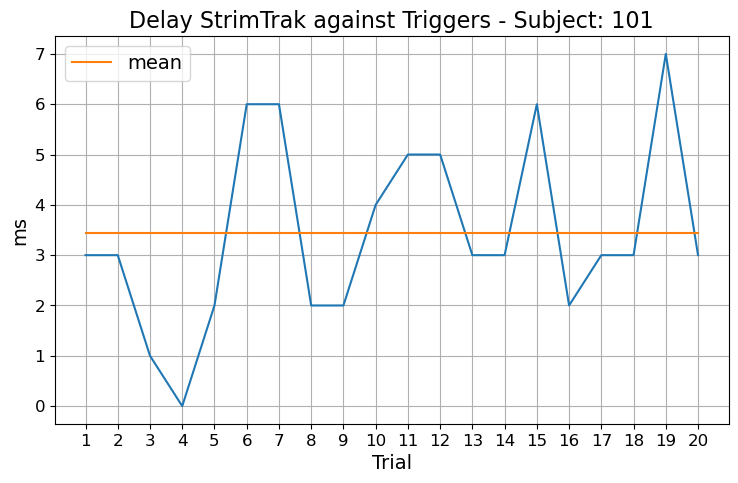

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
fig.tight_layout(pad=3.0)
ax.plot(np.linspace(1,20,20),delays_study)
ax.plot(np.linspace(1,20,20),delays_study_mean.repeat(20), label = 'mean')
ax.set_xticks( np.linspace(1,20,20))
ax.set_xlabel('Trial', fontsize = 14)
ax.set_ylabel('ms', fontsize = 14)
ax.annotate(str(delays_study_mean), (0,0))
ax.set_title('Delay StrimTrak against Triggers - Subject: ' + str(subject), fontsize = 16)
ax.grid()
ax.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(join(target_dir,"delay_stimtrak.pdf"))

**Visually Compare start of audio on ms second level to very calculated delays***

/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/713707320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/713707320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/713707320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/713707320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/713707320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_2

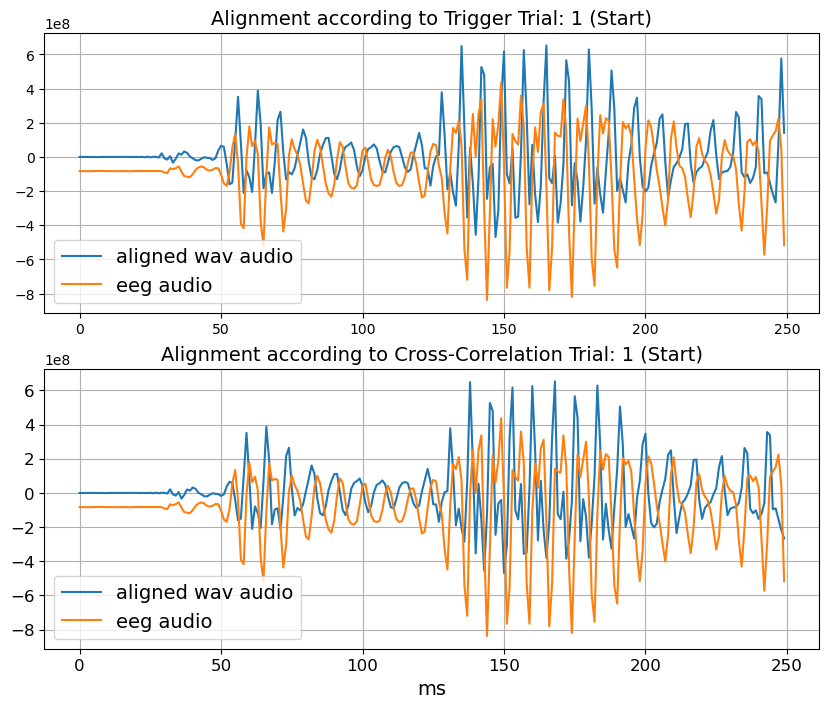

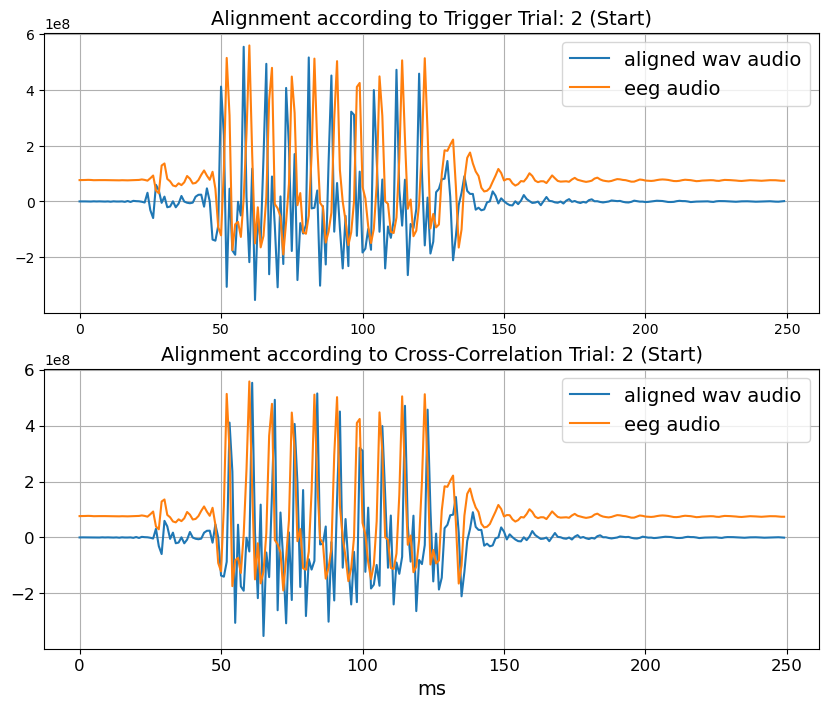

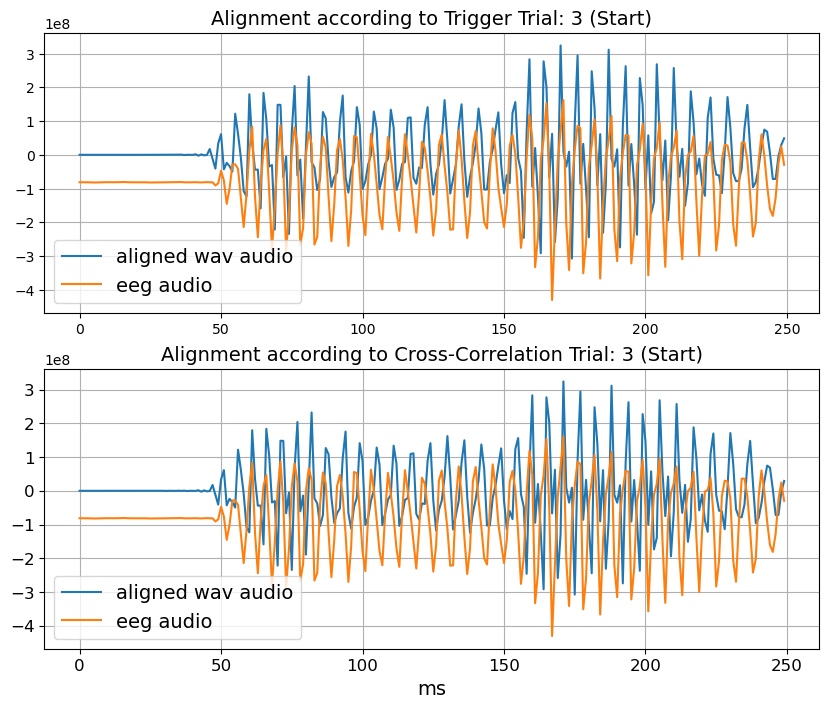

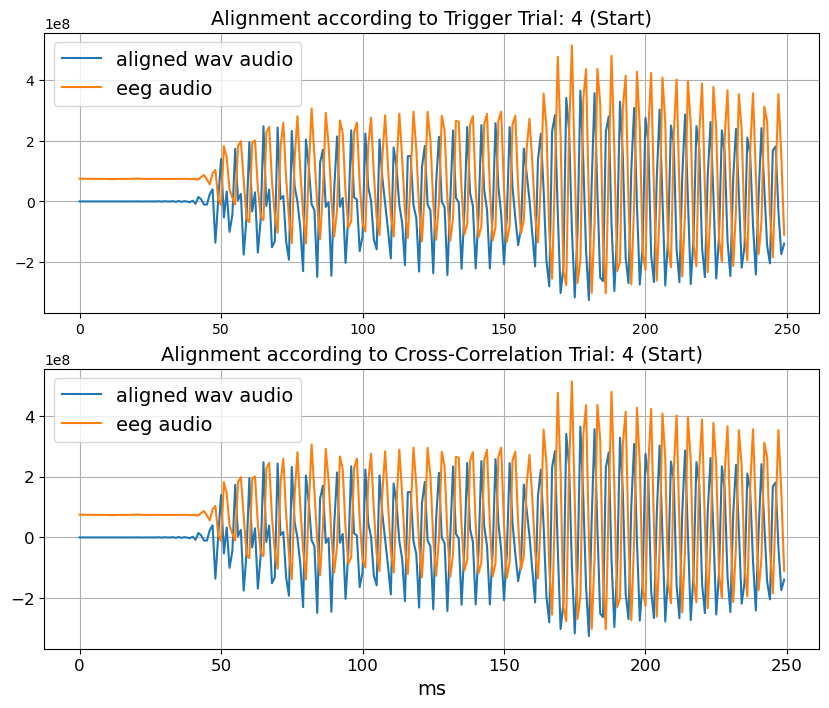

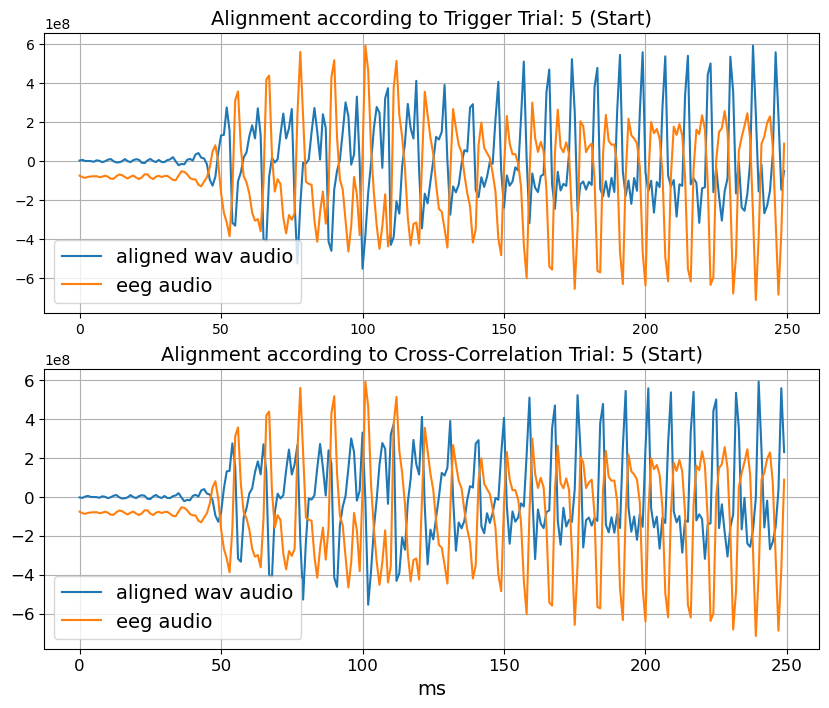

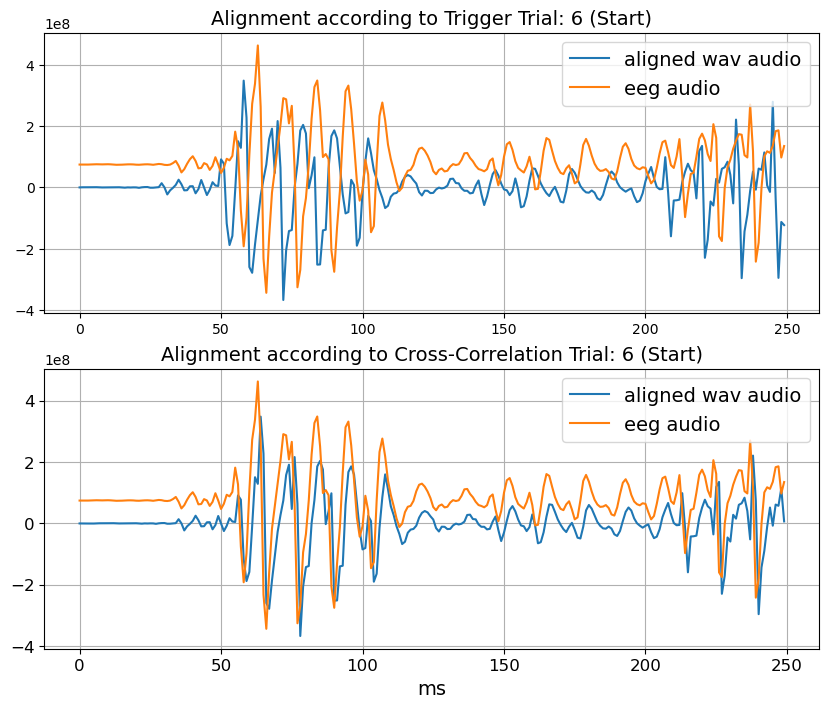

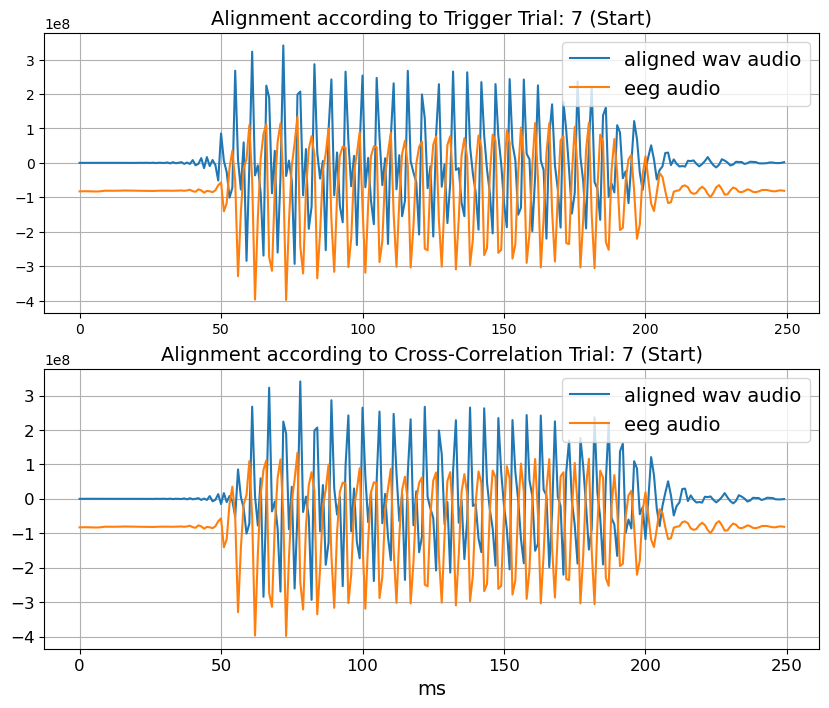

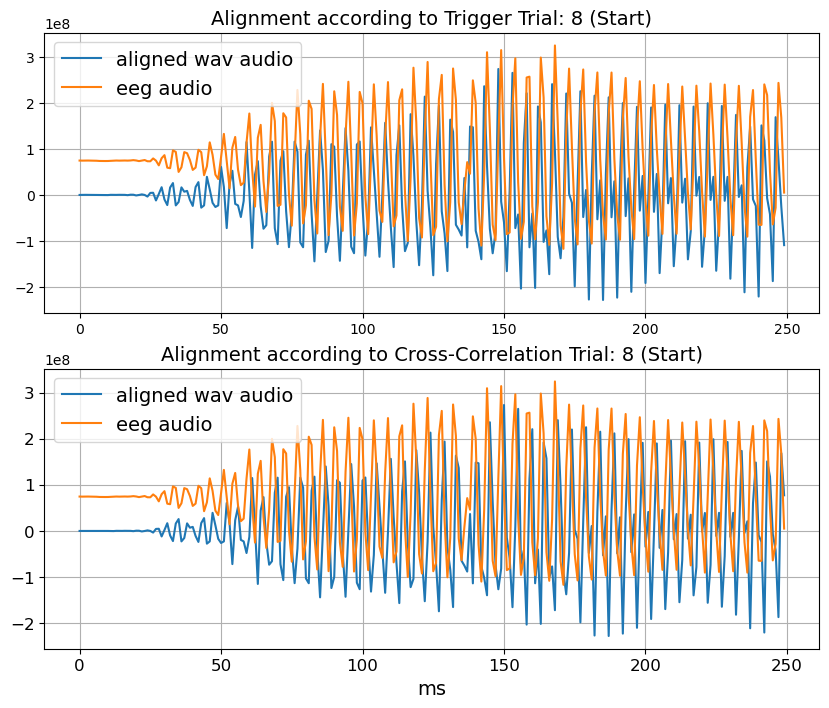

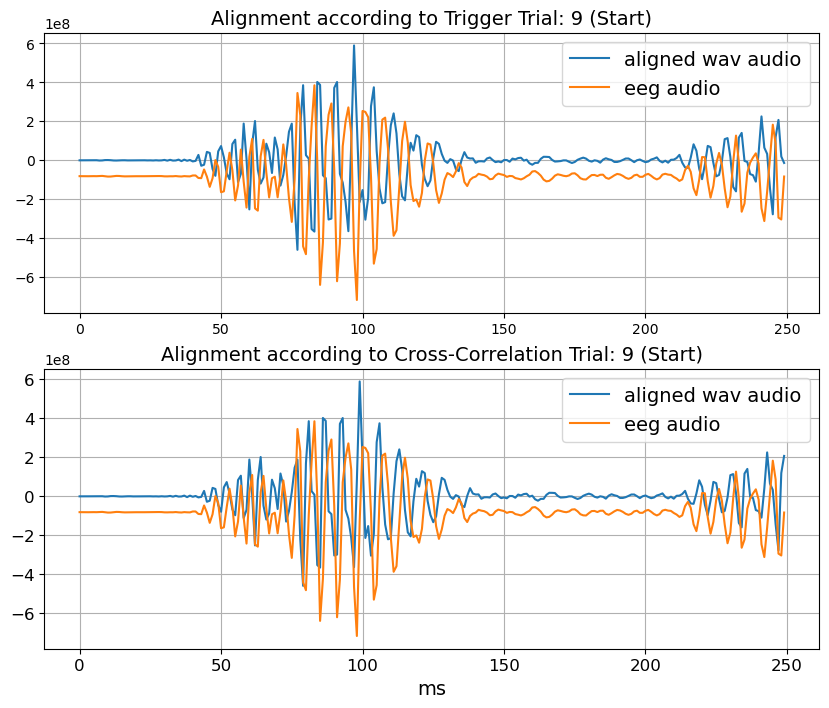

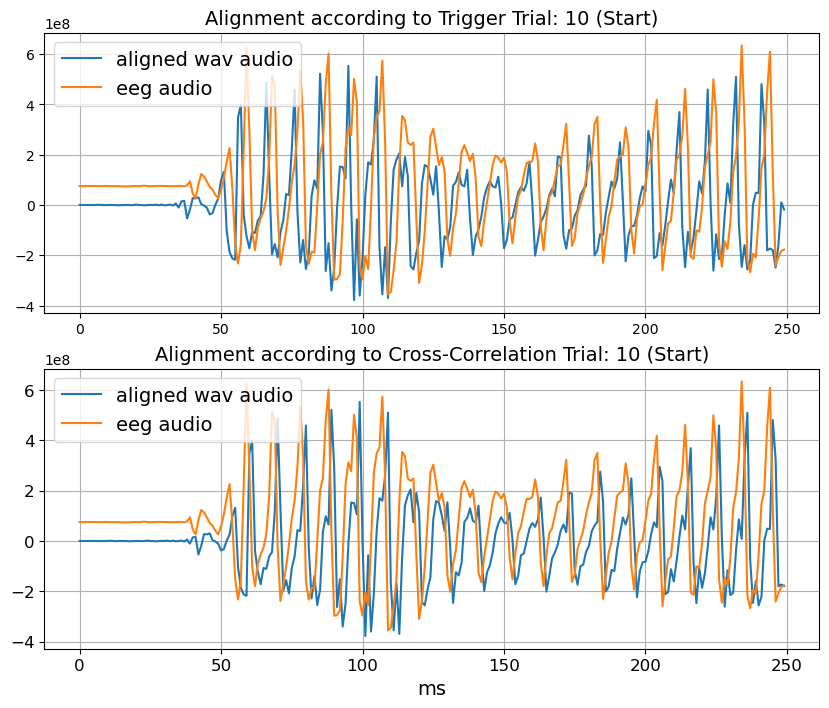

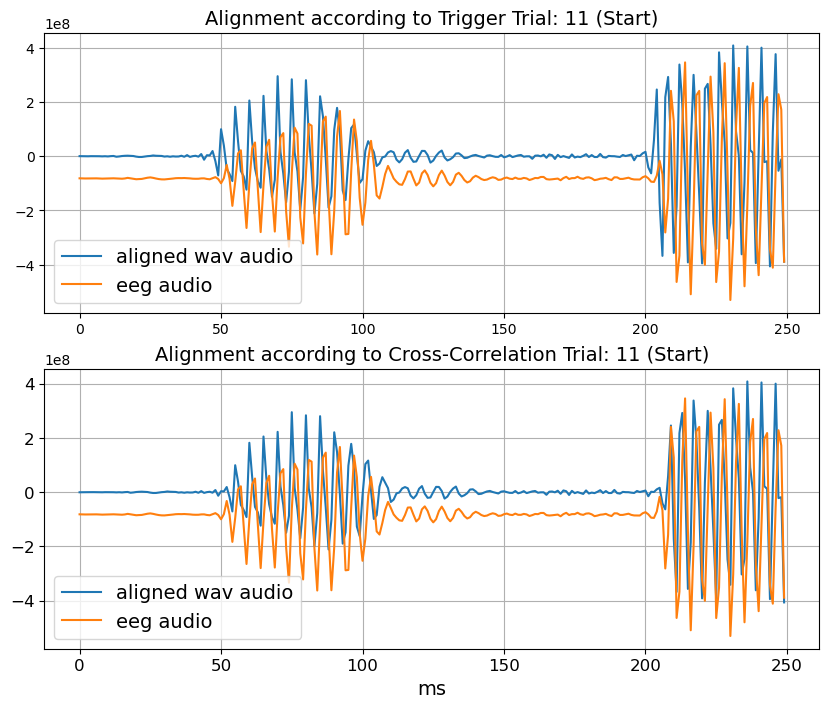

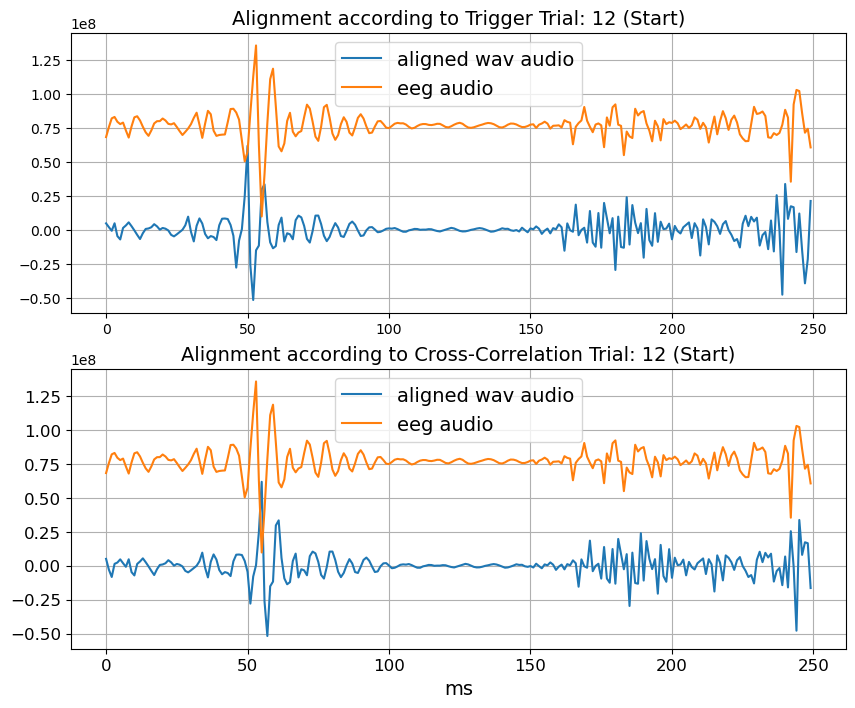

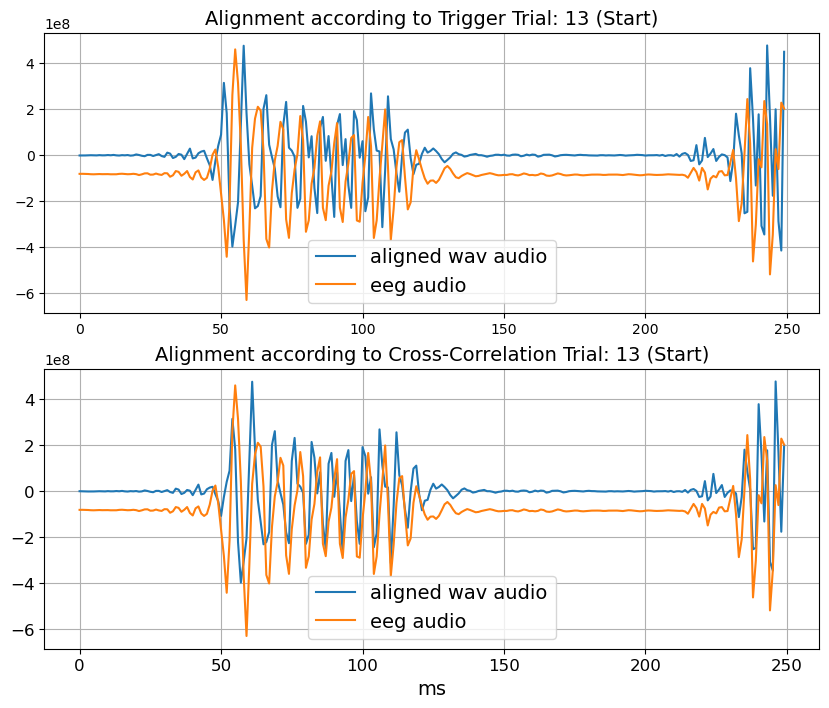

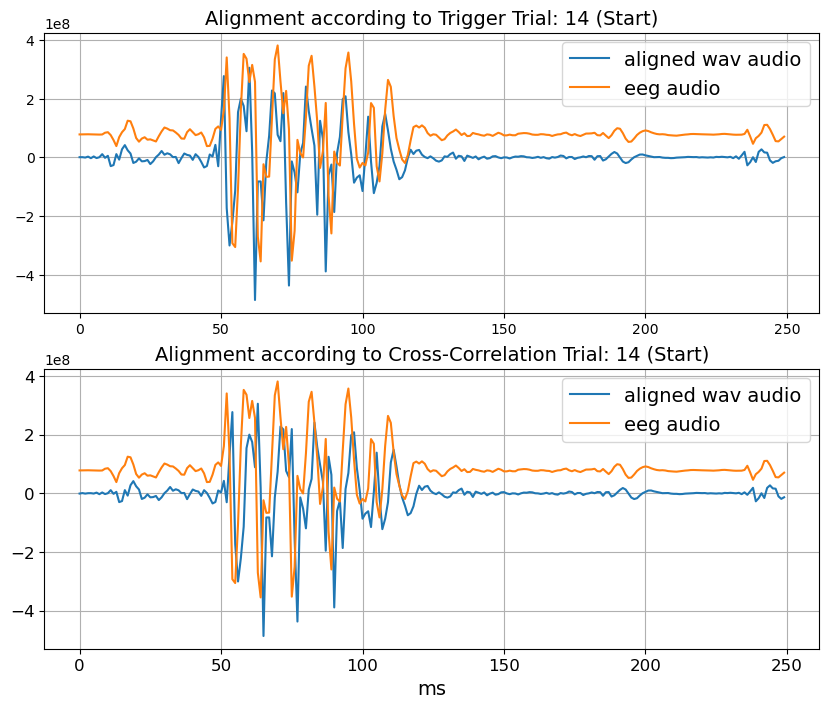

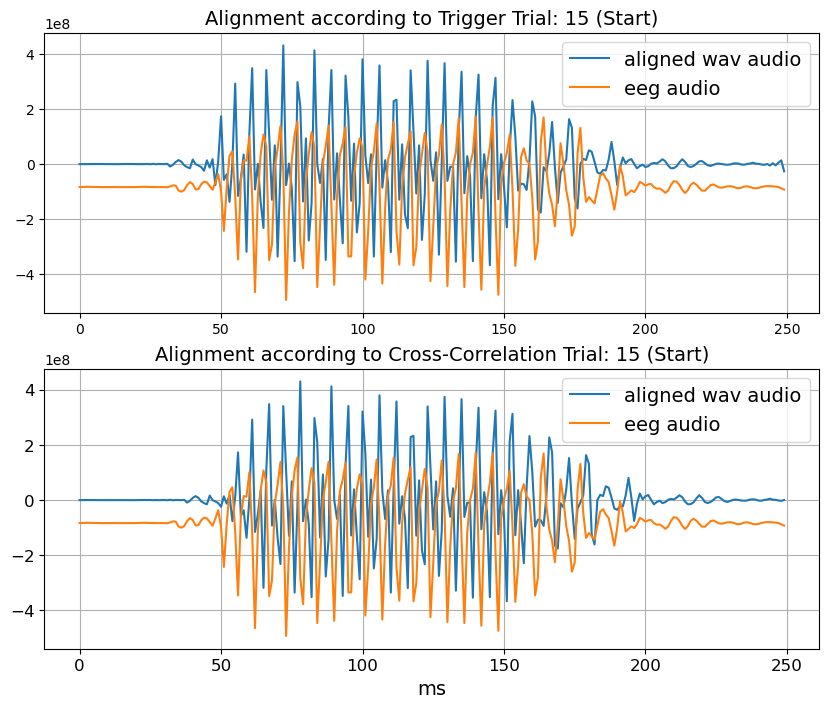

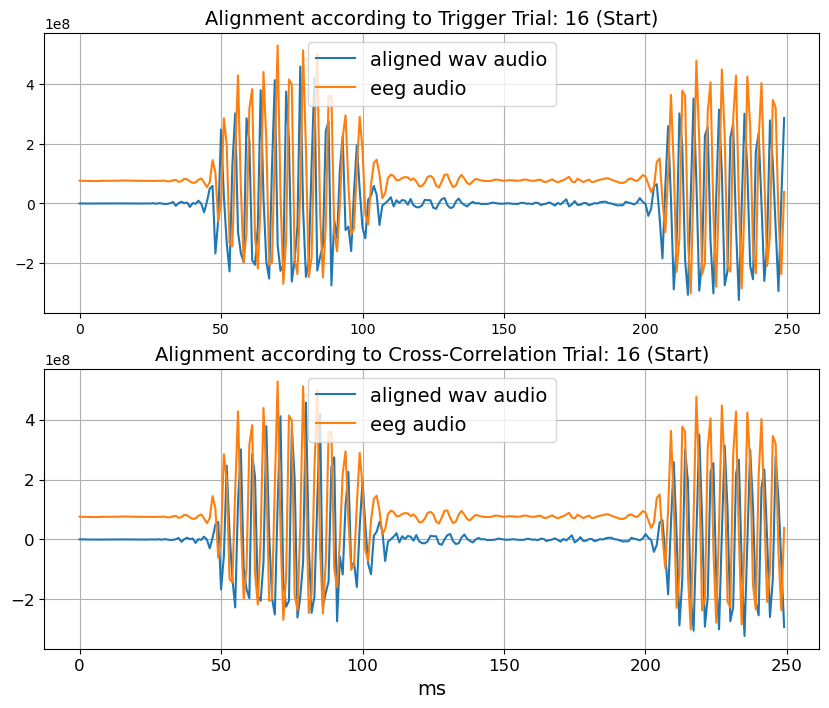

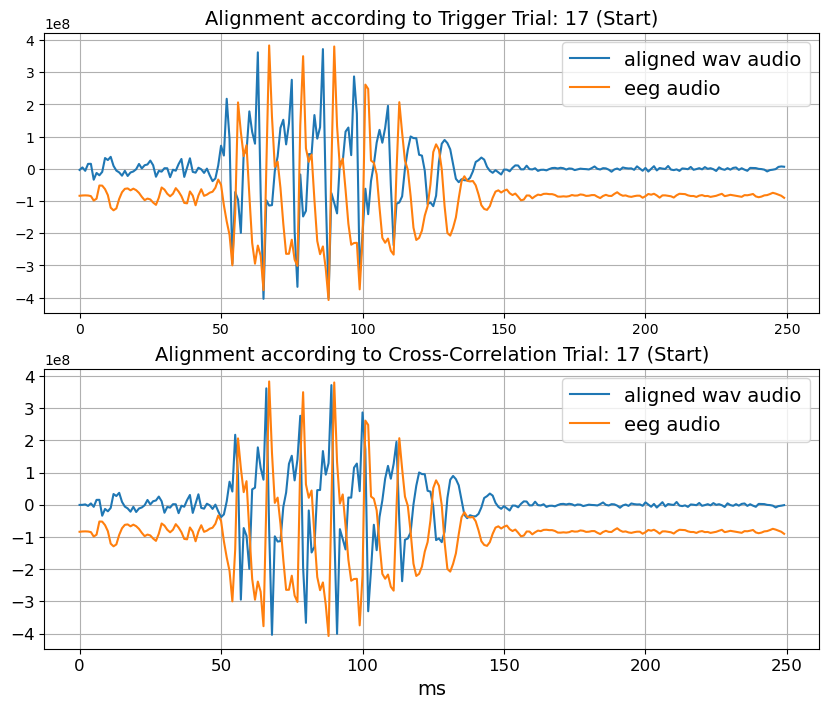

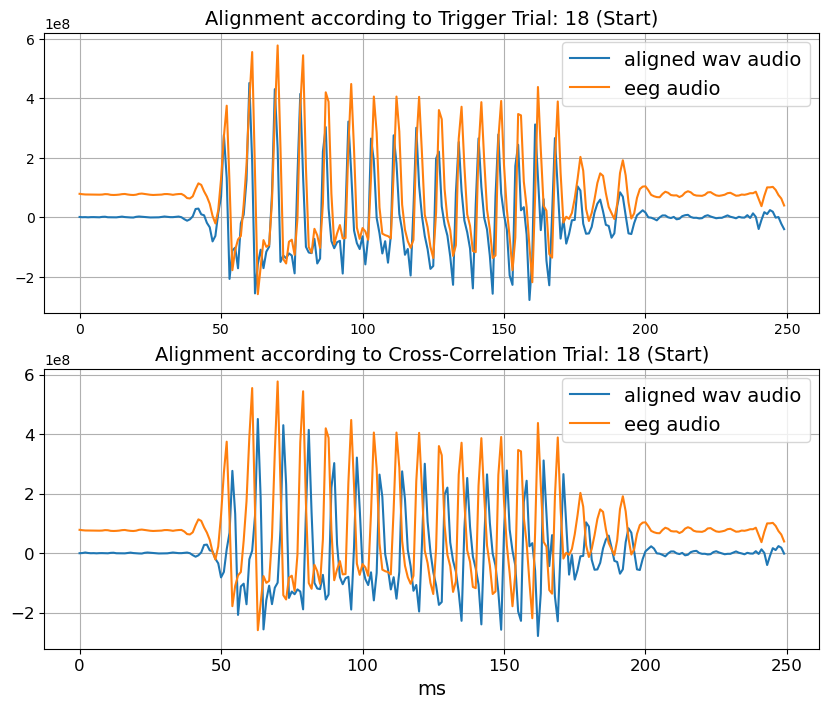

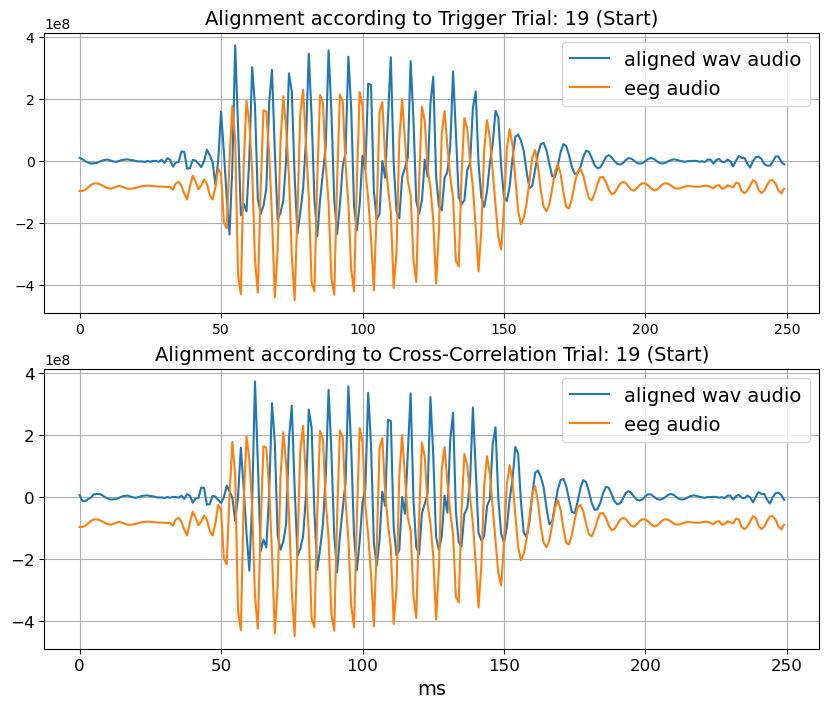

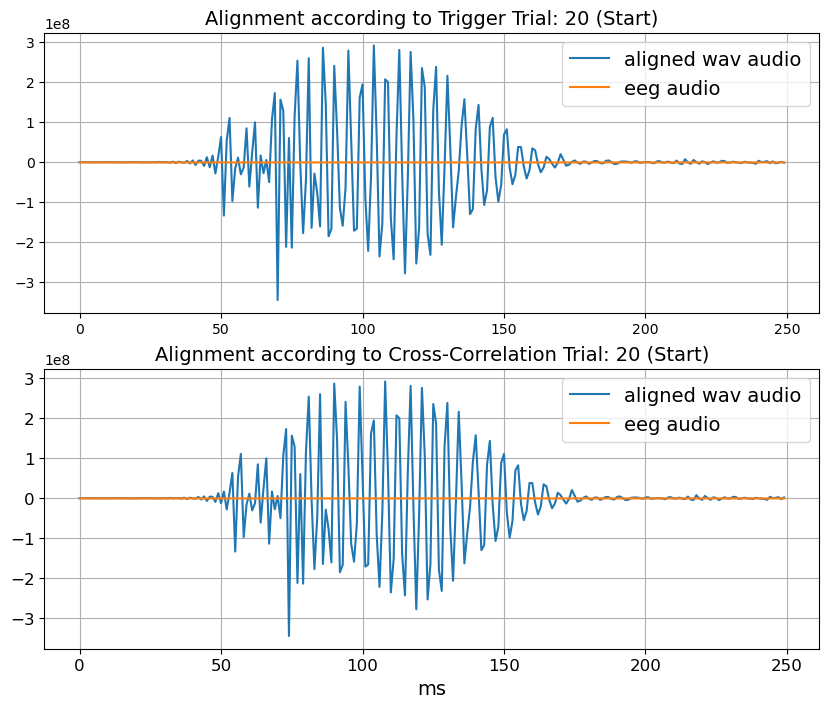

In [11]:
for index in range(0,20):
    stimulus = stimuli_list[index]
    _, stim_wav_0 = read_wav(stimulus['path'])
    stim_wav_0_l, stim_wav_0_r = downsample_wav(stim_wav_0[:,0], stim_wav_0[:,1])

    if stimulus['side'] == 'r':
        stim_wav = stim_wav_0_r
        stim_eeg = stim_eeg_data_r_study[0,:]
    elif stimulus['side'] == 'l':
        stim_wav = stim_wav_0_l
        stim_eeg = stim_eeg_data_l_study[0,:]

    #pad stimulus files to same length as the EEG-Audio
    len_diff = len(stim_eeg) - len(stim_wav)
    stim_wav_aligned_trigger = np.pad(stim_wav,(trigger_indices[index], len_diff - trigger_indices[index]), mode = 'constant', constant_values= (0,0))
    stim_wav_aligned_corr = np.pad(stim_wav,(corr_indices[index], len_diff - corr_indices[index]), mode = 'constant', constant_values= (0,0))

    audio = np.where(stim_wav > 0.6e8)[0]
    start_audio = audio[0]

    #define
    plot_window_bef, plot_window_after = 50, 200
    fig, (ax,ax1) = plt.subplots(2,1, figsize = (10,8))
    ax.plot(stim_wav_aligned_trigger[trigger_indices[index] + start_audio - plot_window_bef :trigger_indices[index] + start_audio + plot_window_after], label = 'aligned wav audio')
    ax.plot(np.multiply(stim_eeg[trigger_indices[index] + start_audio - plot_window_bef : trigger_indices[index] + start_audio + plot_window_after], 4e8), label = 'eeg audio')
    ax.legend(fontsize = 14)
    ax.set_title("Alignment according to Trigger Trial: " + str(index +1) + " (Start)", fontsize = 14)
    ax.grid()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    ax1.plot(stim_wav_aligned_corr[trigger_indices[index] + start_audio - plot_window_bef:trigger_indices[index] + start_audio + plot_window_after], label = 'aligned wav audio')
    ax1.plot(np.multiply(stim_eeg[trigger_indices[index] + start_audio - plot_window_bef :trigger_indices[index] + start_audio + plot_window_after],4e8), label = 'eeg audio')
    ax1.set_title("Alignment according to Cross-Correlation Trial: " + str(index +1) + " (Start)", fontsize = 14)
    ax1.grid()
    ax1.legend(fontsize = 14)
    ax1.set_xlabel('ms', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.savefig(join(target_dir,"start_" + str(index + 1)+ ".pdf"))

/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/2009497027.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/2009497027.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/2009497027.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/2009497027.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_28810/2009497027.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, stim_wav_0 = read_wav(stimulus['path'])
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipyker

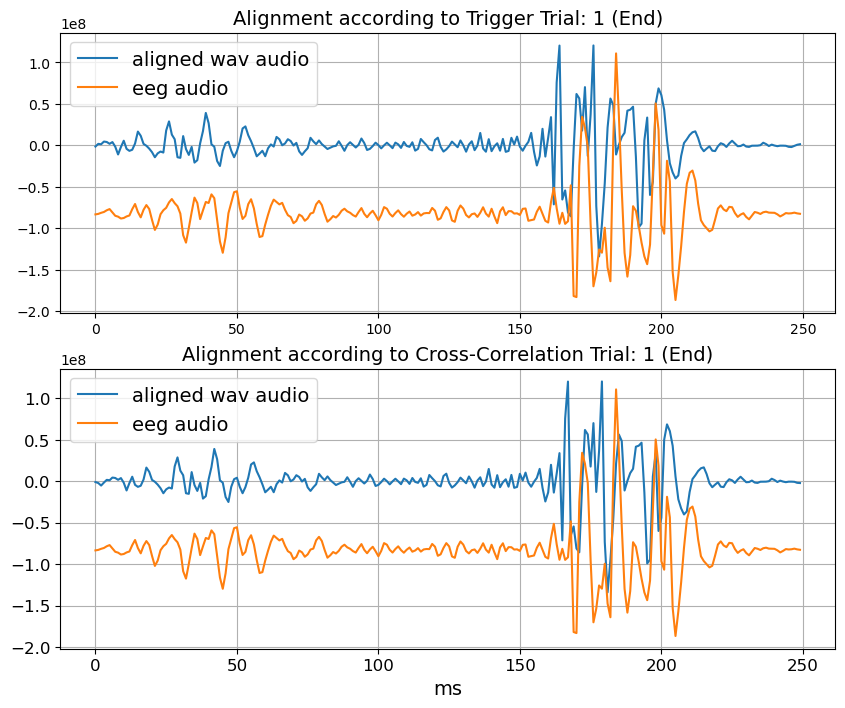

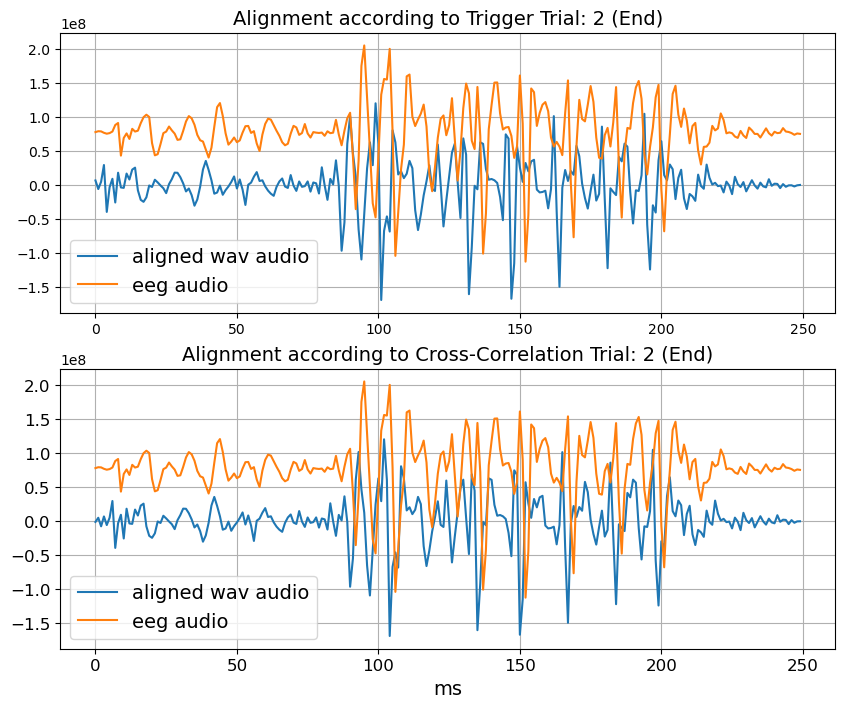

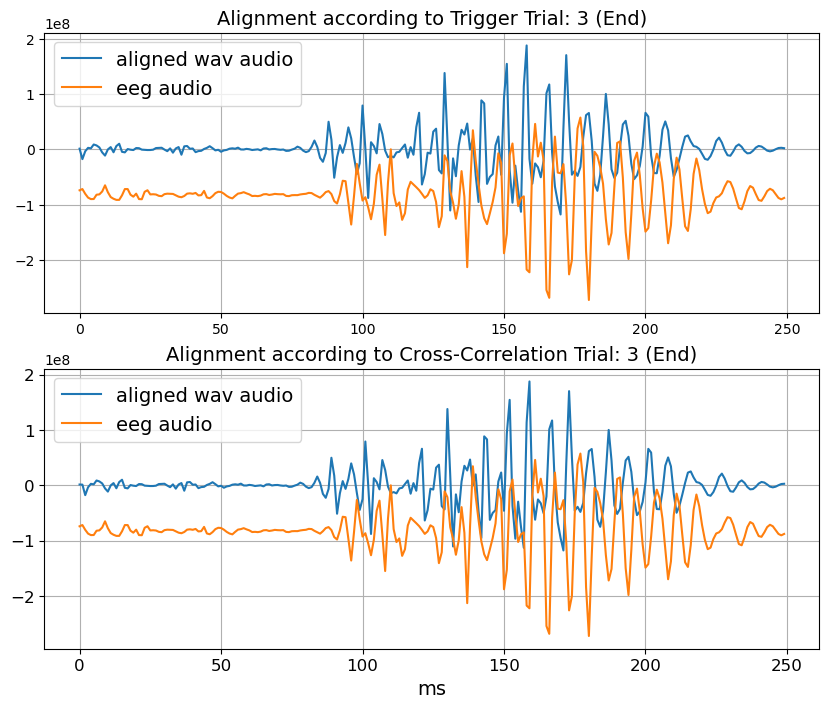

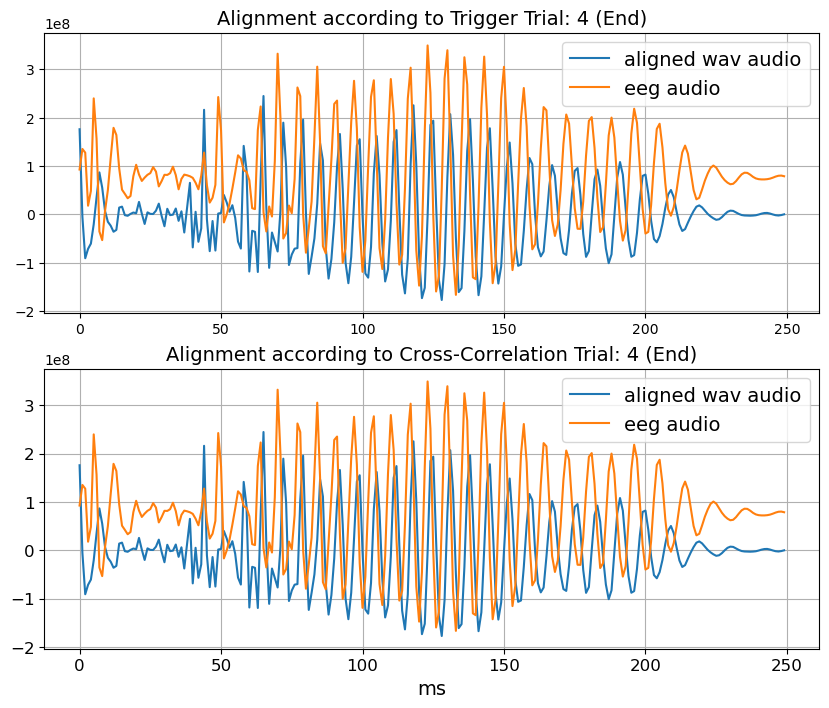

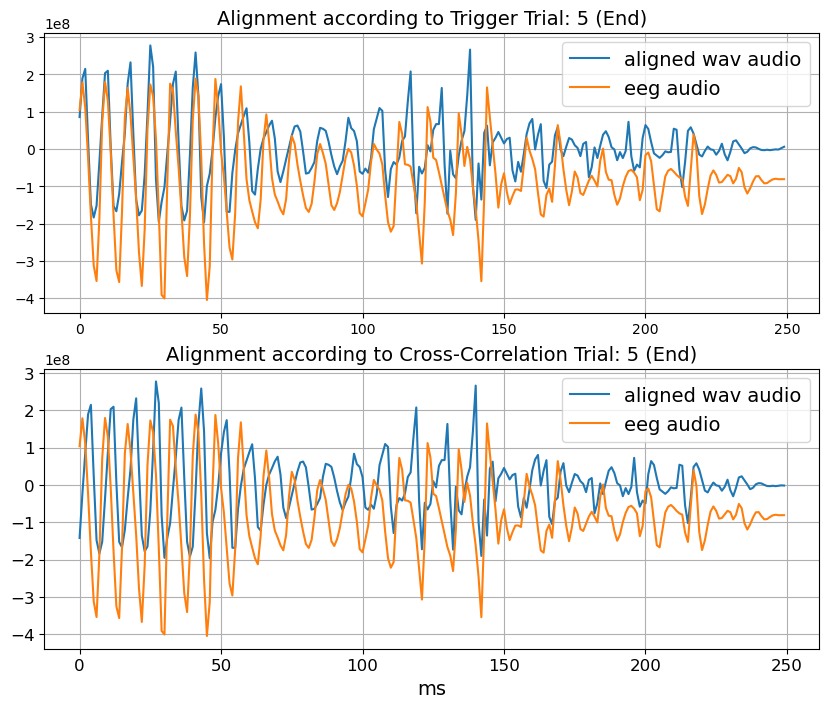

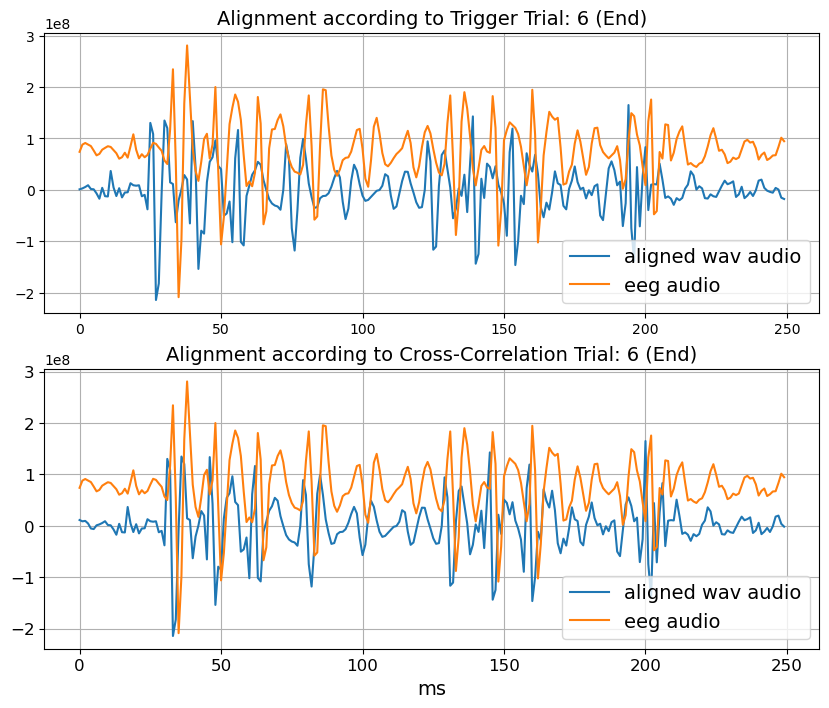

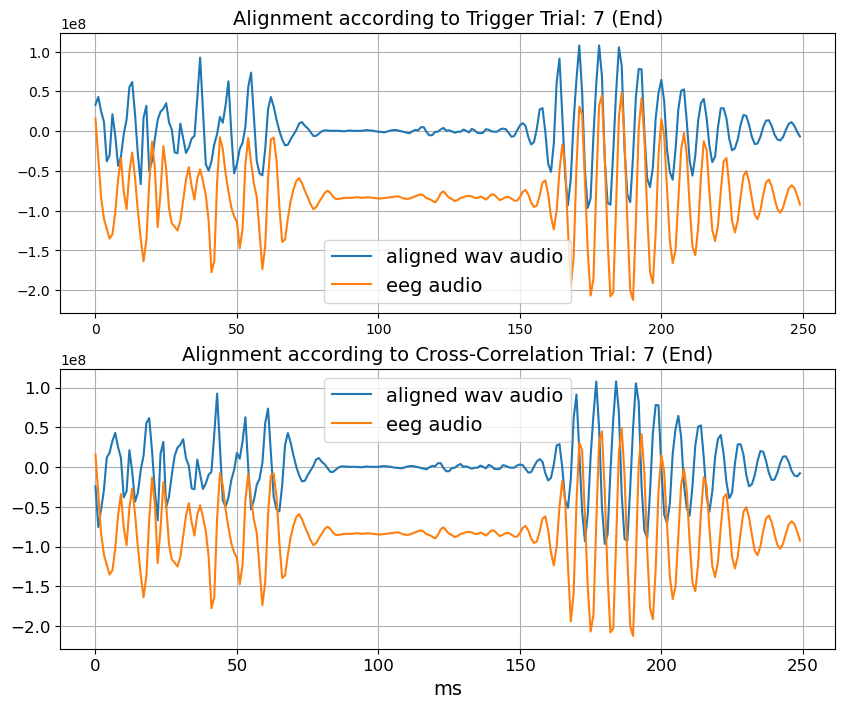

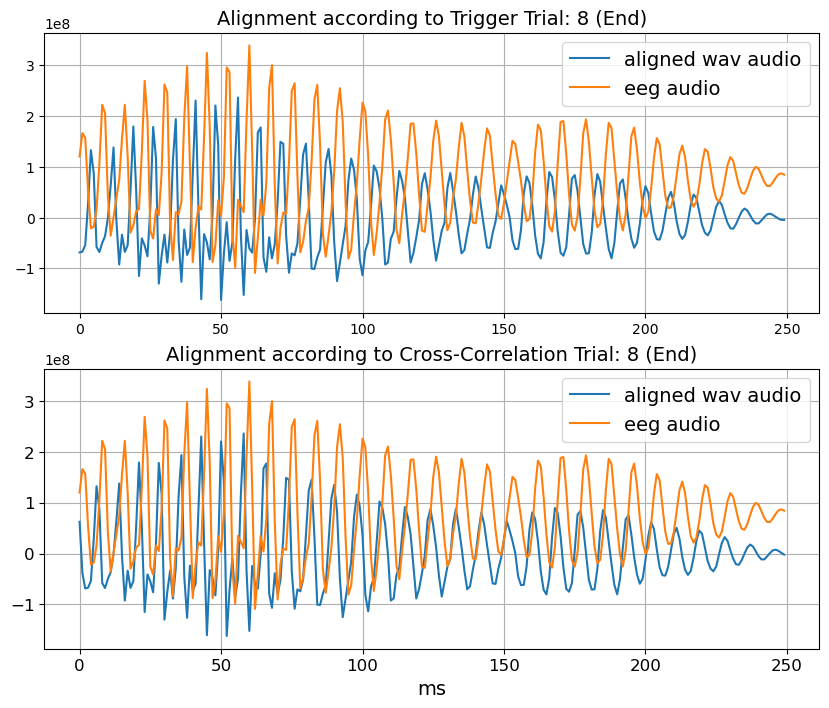

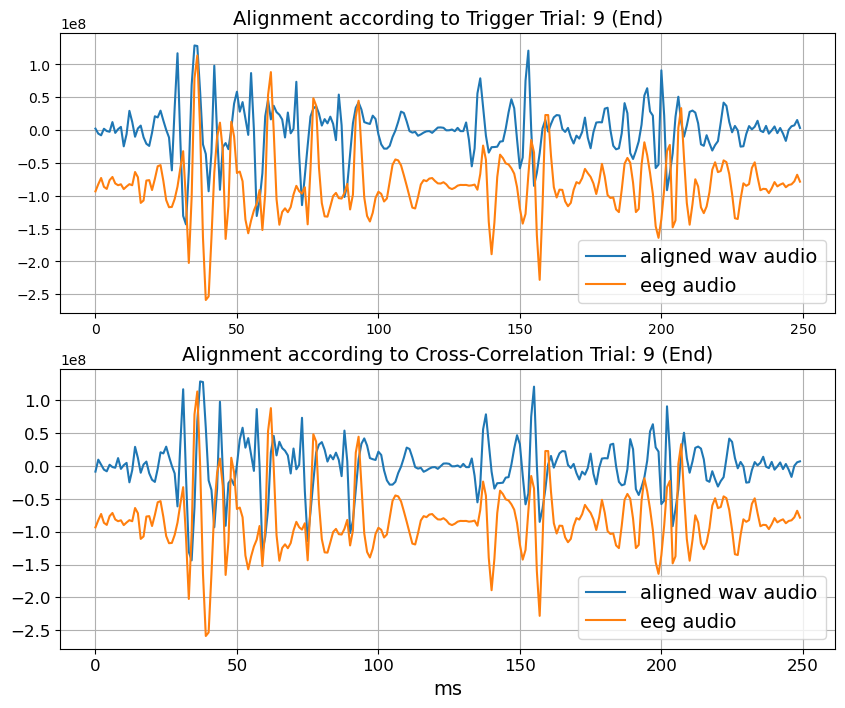

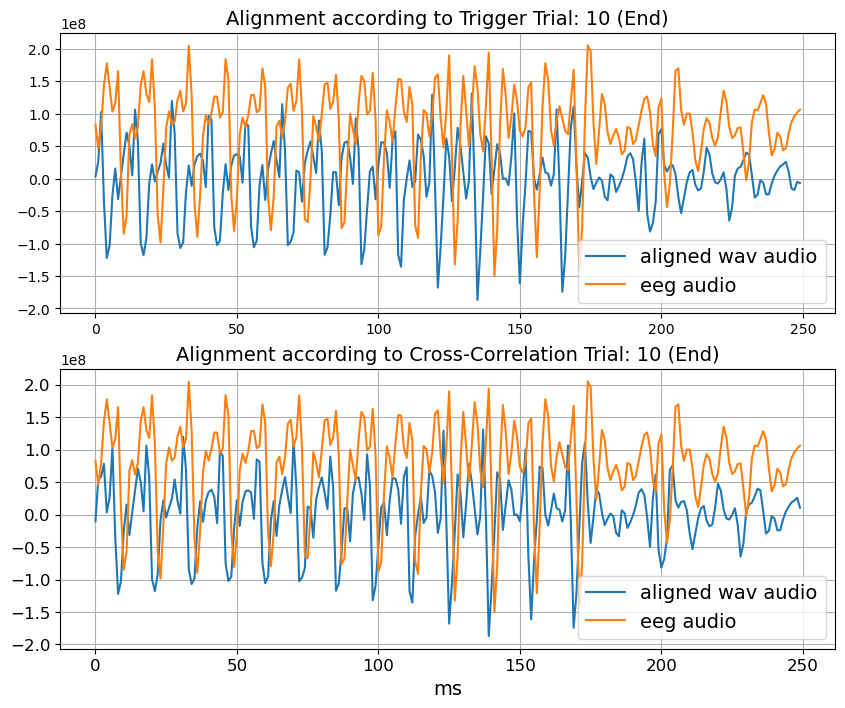

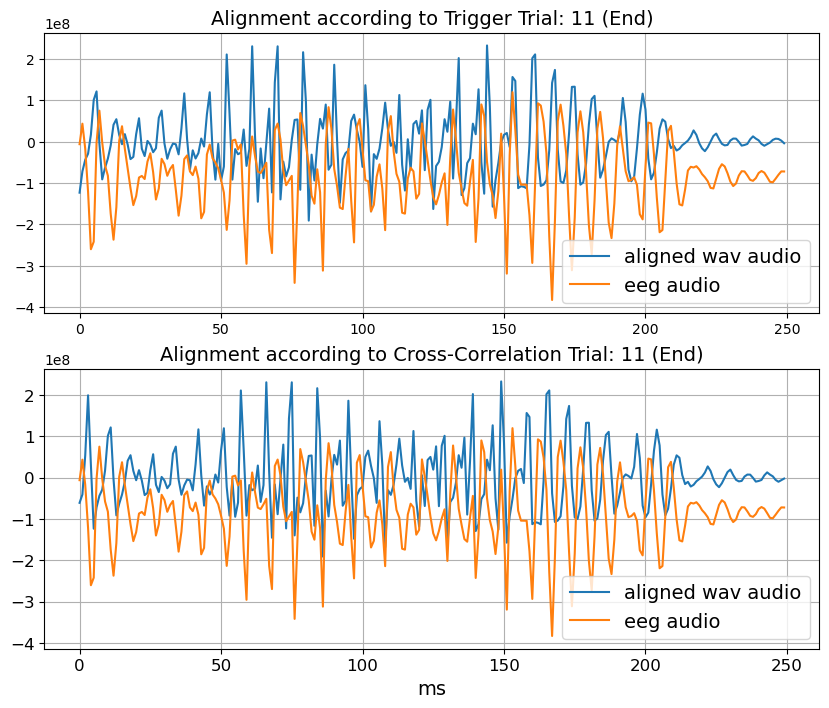

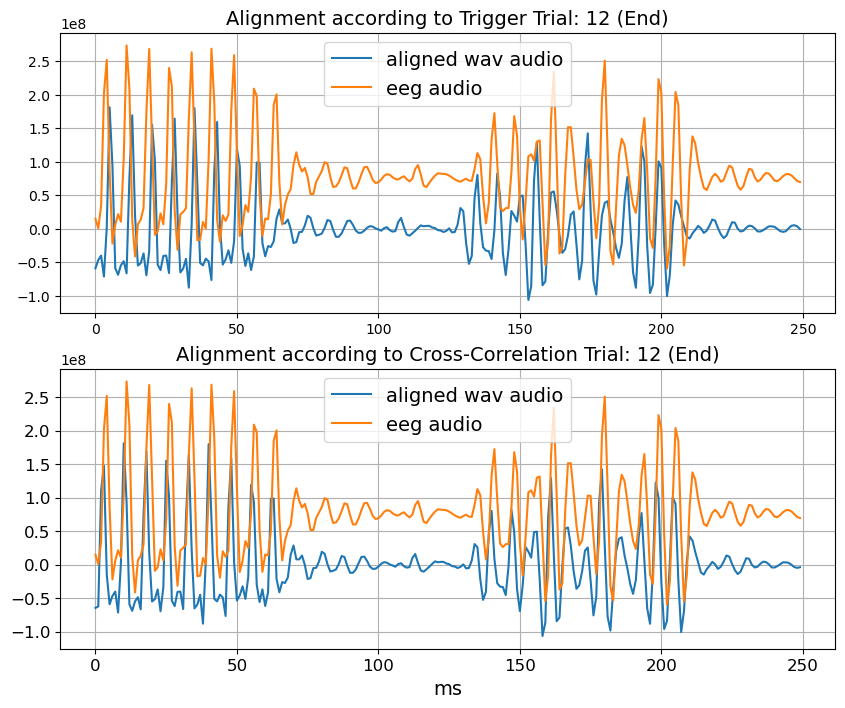

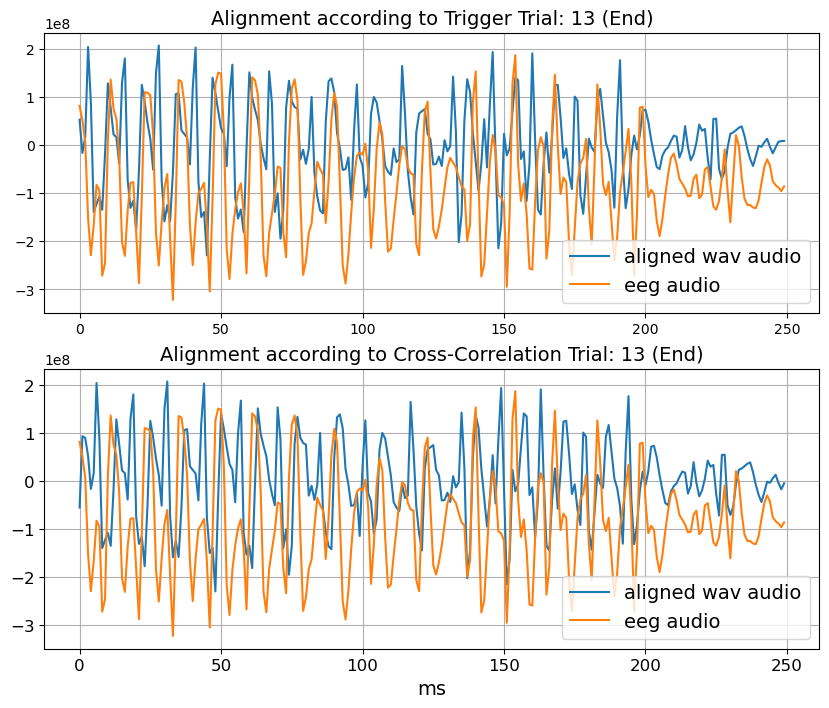

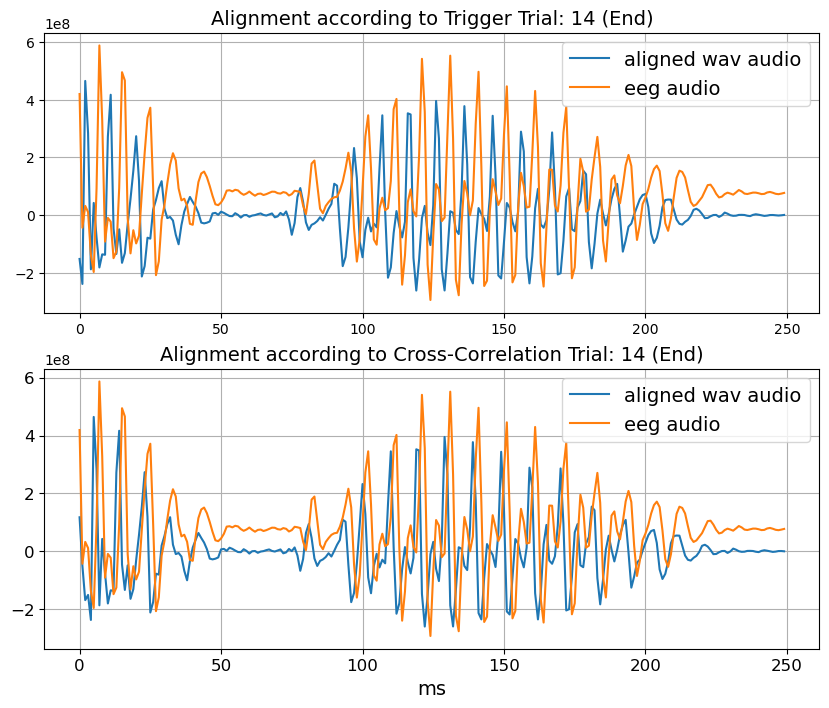

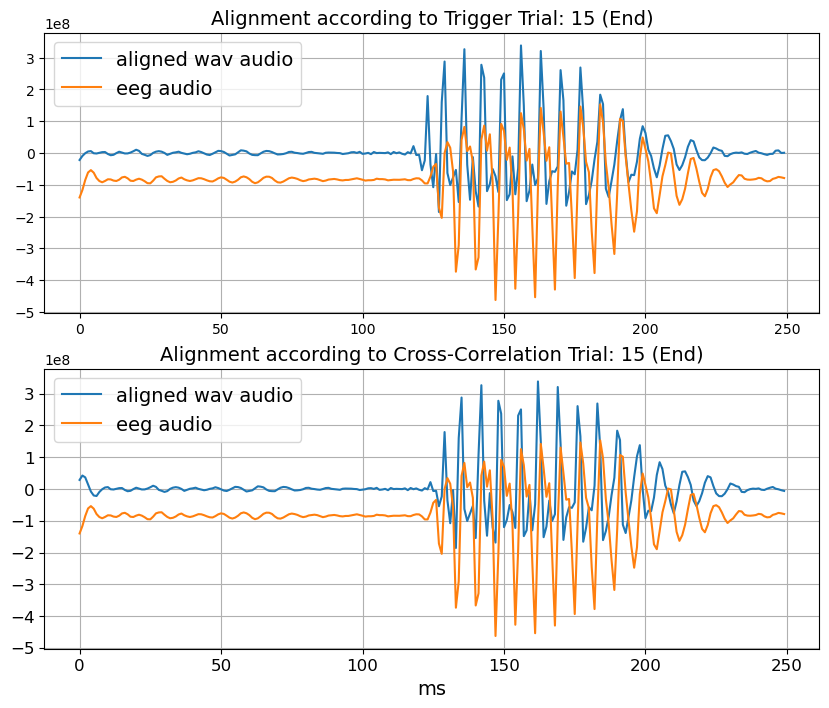

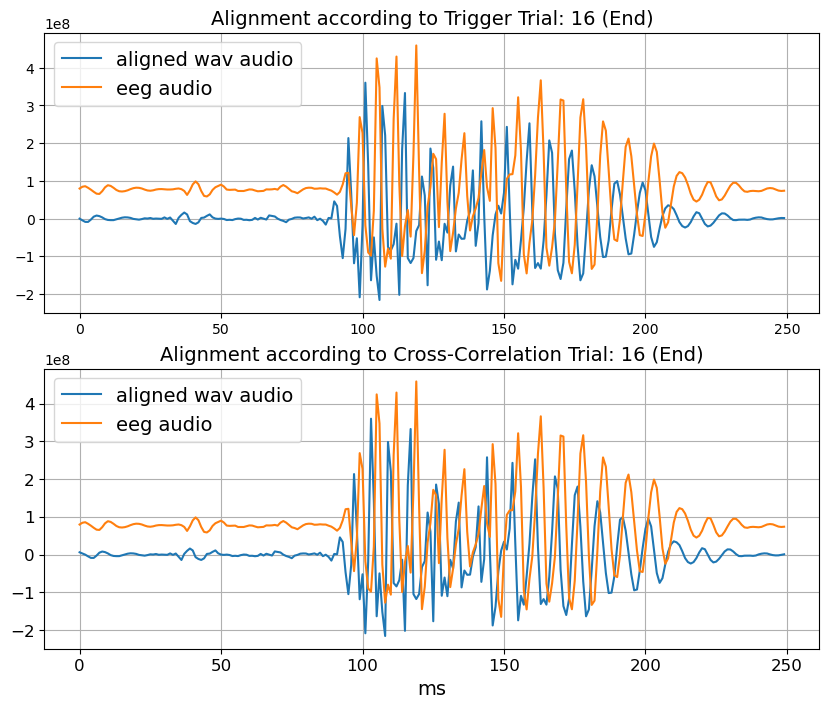

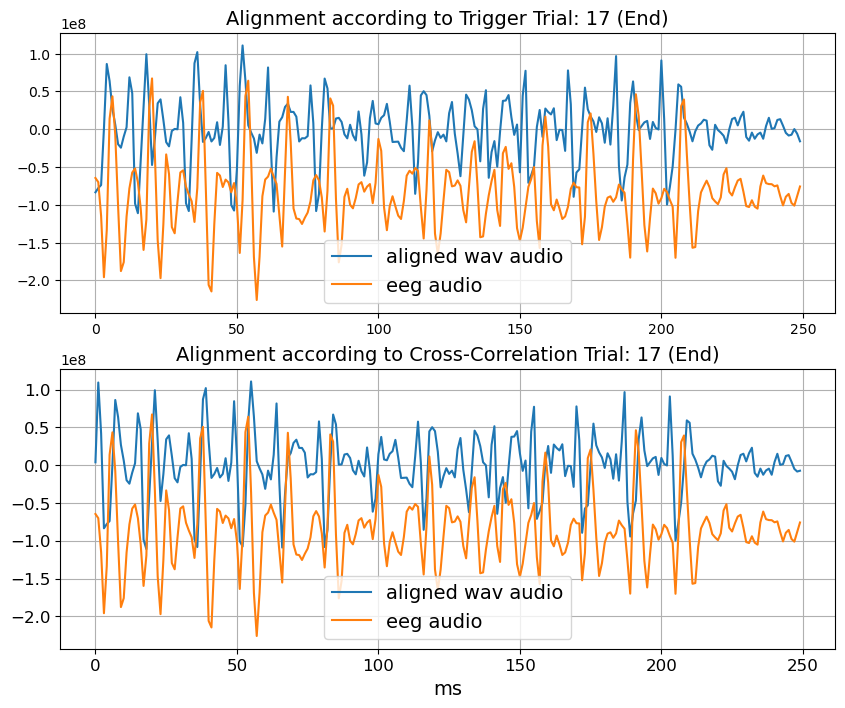

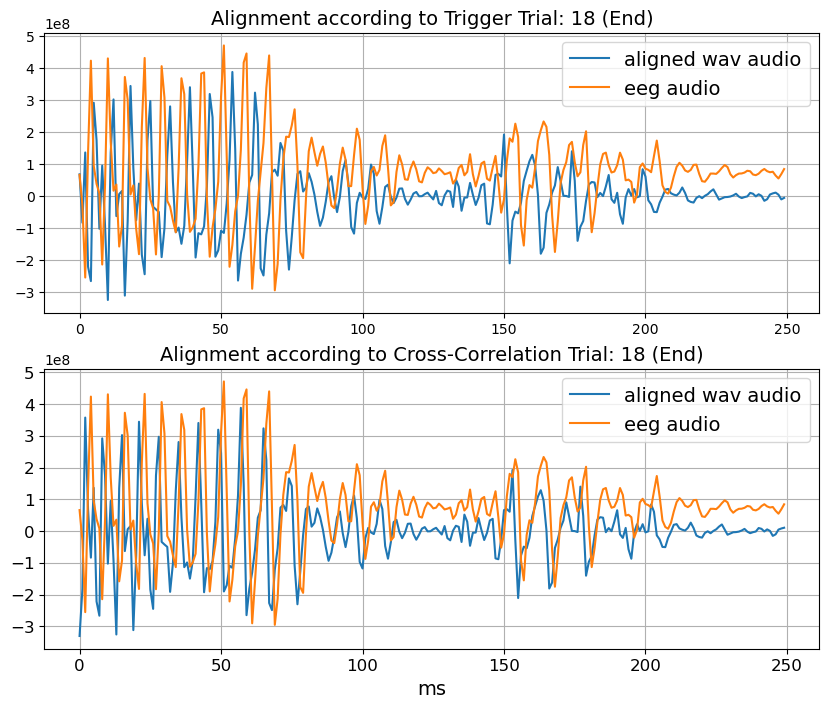

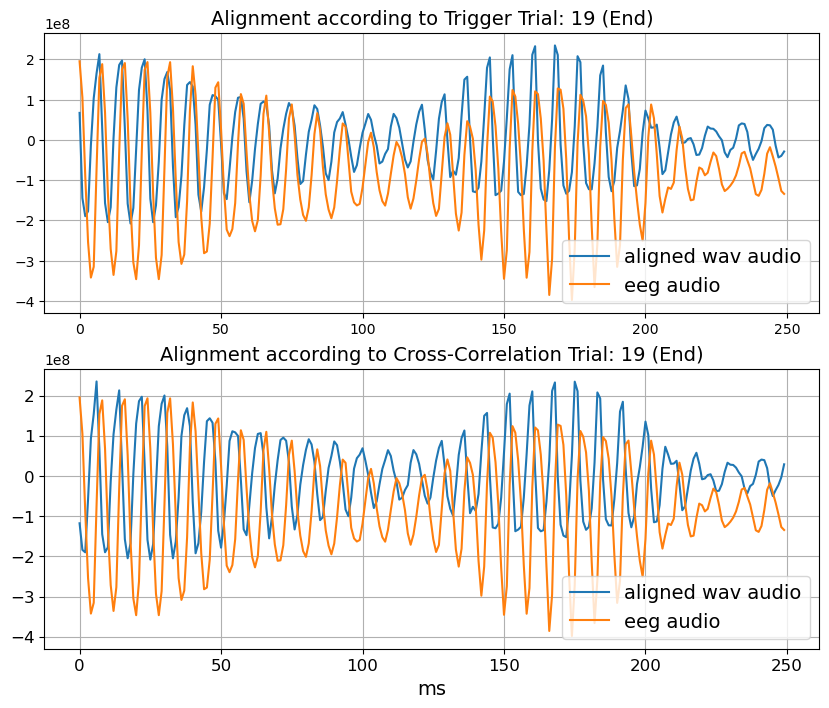

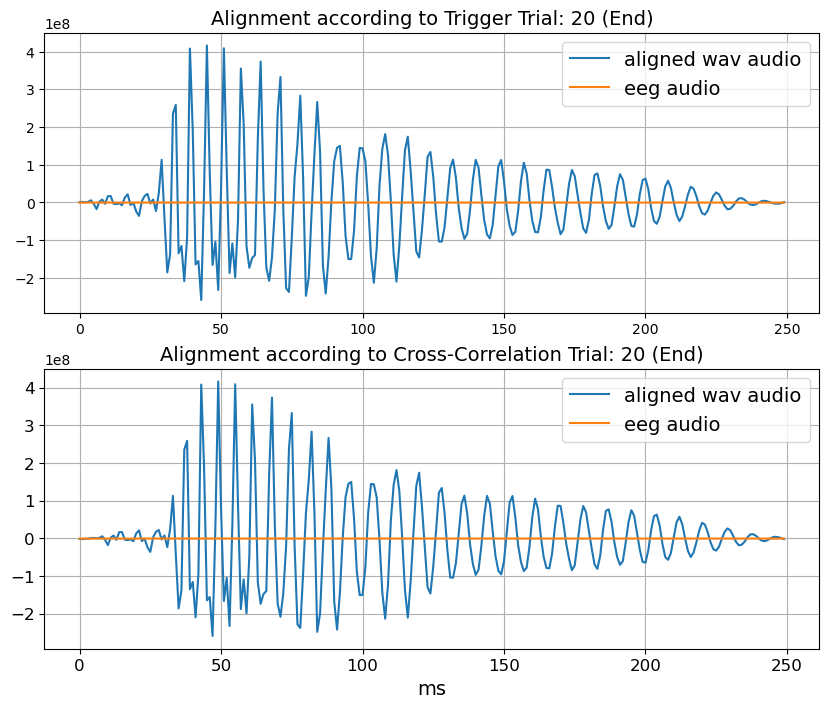

In [12]:
for index in range(0,20):
    stimulus = stimuli_list[index]
    _, stim_wav_0 = read_wav(stimulus['path'])
    stim_wav_0_l, stim_wav_0_r = downsample_wav(stim_wav_0[:,0], stim_wav_0[:,1])

    audio_length = len(stim_wav_0_l)

    if stimulus['side'] == 'r':
        stim_wav = stim_wav_0_r
        stim_eeg = stim_eeg_data_r_study[0,:]
    elif stimulus['side'] == 'l':
        stim_wav = stim_wav_0_l
        stim_eeg = stim_eeg_data_l_study[0,:]

    len_diff = len(stim_eeg) - len(stim_wav)
    stim_wav_aligned_trigger = np.pad(stim_wav,(trigger_indices[index],len_diff - trigger_indices[index]), mode = 'constant', constant_values= (0,0))
    stim_wav_aligned_corr = np.pad(stim_wav,(corr_indices[index],len_diff - corr_indices[index]), mode = 'constant', constant_values= (0,0))

    audio = np.where(stim_wav > 0.6e8)[0]
    end_audio = audio[-1]

    #define
    plot_window_bef, plot_window_after = 200, 50
    fig, (ax,ax1) = plt.subplots(2,1, figsize = (10,8))
    ax.plot(stim_wav_aligned_trigger[trigger_indices[index] + end_audio - plot_window_bef :trigger_indices[index] + end_audio + plot_window_after], label = 'aligned wav audio')
    ax.plot(np.multiply(stim_eeg[trigger_indices[index] + end_audio - plot_window_bef : trigger_indices[index] + end_audio + plot_window_after], 4e8), label = 'eeg audio')
    ax.legend(fontsize = 14)
    ax.set_title("Alignment according to Trigger Trial: " + str(index +1) + " (End)", fontsize = 14)
    ax.grid()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    ax1.plot(stim_wav_aligned_corr[trigger_indices[index] + end_audio - plot_window_bef:trigger_indices[index] + end_audio + plot_window_after], label = 'aligned wav audio')
    ax1.plot(np.multiply(stim_eeg[trigger_indices[index] + end_audio - plot_window_bef :trigger_indices[index] + end_audio + plot_window_after],4e8), label = 'eeg audio')
    ax1.set_title("Alignment according to Cross-Correlation Trial: " + str(index +1) + " (End)", fontsize = 14)
    ax1.grid()
    ax1.legend(fontsize = 14)
    ax1.set_xlabel('ms', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.savefig(join(target_dir,"end_" + str(index + 1)+ ".pdf"))

**Make Verbose Alignment for visualisation**

In [ ]:
stimulus = stimuli_list[0]
_, stim_wav_0 = read_wav(stimulus['path'])

stim_wav_0_l, stim_wav_0_r = downsample_wav(stim_wav_0[:,0], stim_wav_0[:,1])

if stimulus['side'] == 'r':
    lag_index, _, confident = align_stim_wav(stim_eeg_data_r_study[0,:] ,stim_wav_0_r, plot = True)
elif stimulus['side'] == 'l':
    lag_index, _, confident = align_stim_wav(stim_eeg_data_l_study[0,:] ,stim_wav_0_l, plot = True)
print(confident)
print(stimulus)